In [43]:
# Librairie & paramètres
import pandas as pd
import lib
import matplotlib.pyplot as plt
import numpy as np

param = {

    # Direction vers les fichiers GeoSRA
    "GeoSRA DIR IN" :"../../data/processed/geosra_clean.parquet.gzip",
    "GeoSRA DIR OUT":"../../data/processed/geosra_clean_cluster.parquet.gzip",

    # Dates pour les histogrammes
    "Start Year"    :2010,
    "End Year"      :2024,

    # Epaisseur des barres par défault
    "Width Bar"     :0.5,

    # Seuils pour les fonctions de répartition et le dendogramme
    "Repart Thr"    :0.95,
    "Semant Thr"    :3.5,
 
    # Classe d'assay type principales
    "Assay Class"   :['AMPLICON','WGS','RNA-Seq','WGA'],

    # Couleurs
    "Clusters Color":["darkorange","limegreen","darkred","rebeccapurple","saddlebrown","pink","gray","lightgreen","cyan","black"],
    "Assays Color"  :["skyblue","salmon","lemonchiffon","palegreen","silver"]

}

In [44]:
# Ouvre GeoSRA et affiche les colonnes
geosra_pd = pd.read_parquet(param["GeoSRA DIR IN"])
geosra_pd.columns

ArrowMemoryError: realloc of size 134217728 failed

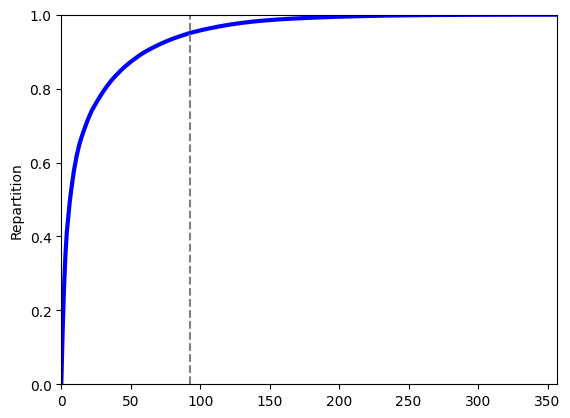

In [ ]:
# Fonction de répartition de la colonne organism
count  = dict(geosra_pd["organism"].value_counts())
repa,thr = lib.repartition(count,t=param["Repart Thr"])

c:\Users\thillairet\OneDrive - ENSG Géomatique\Documents\git\viromatlas-wastewater\code\lib.py:109: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  dist_matrix[i, j] = nlp(chains[i]).similarity(nlp(chains[j]))


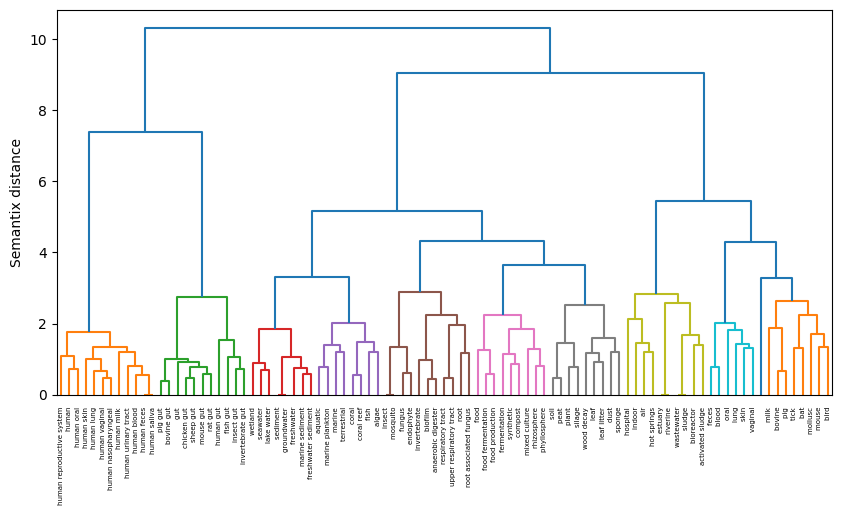

In [ ]:
# Dendogramme (Sémantique) des principales valeurs de organism
chains = list(count.keys())[:thr]
chains = [chain.replace('metagenome', '') for chain in chains]
dend = lib.semantix_dendogram(chains, ct=param["Semant Thr"])

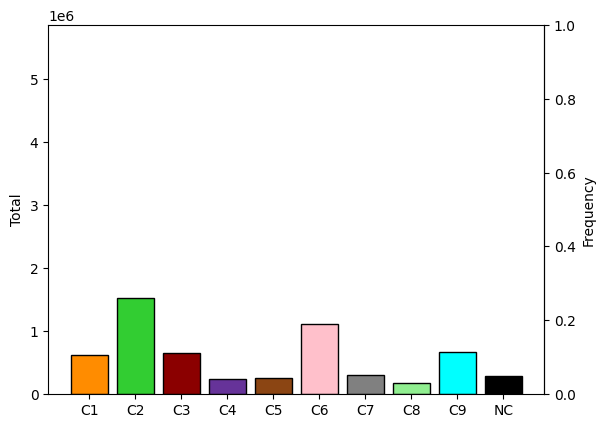

In [ ]:
# Création de la colonne cluster_organism et histogramme des clusters
keys = [key+'metagenome' for key in dend['ivl']]
class_dict = dict(zip(keys,dend["leaves_color_list"]))
geosra_pd["cluster_organism"] = geosra_pd["organism"].map(class_dict)
geosra_pd["cluster_organism"] = geosra_pd["cluster_organism"].fillna('NC')
count = dict(geosra_pd["cluster_organism"].value_counts())
count_cl = dict(sorted(count.items()))
lib.norm_hist(count_cl,colors=param["Clusters Color"])

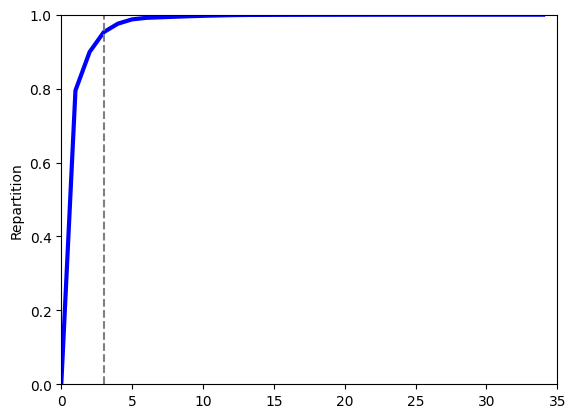

In [ ]:
# Fonction de répartition de assay_type
value_counts  = dict(geosra_pd["assay_type"].value_counts())
repa,thr = lib.repartition(value_counts,t=param["Repart Thr"])

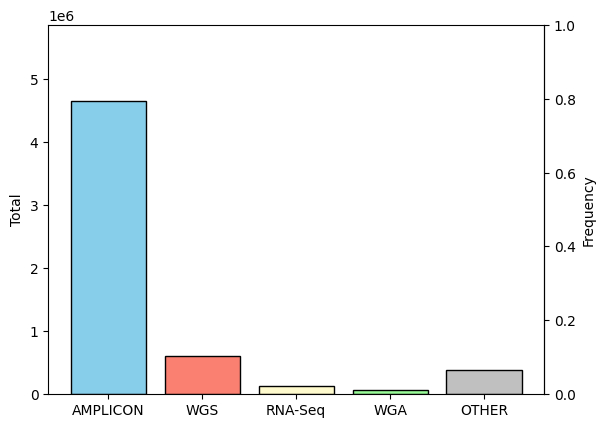

In [ ]:
# Histogramme de assay_type
classes = param["Assay Class"]
count_assay = {}
for classe in classes:
    count_assay[classe] = value_counts[classe]
nb_others = 0
for key, value in value_counts.items():
    if not key in classes:
        nb_others += value
count_assay['OTHER'] = nb_others
lib.norm_hist(count_assay,colors=param["Assays Color"])

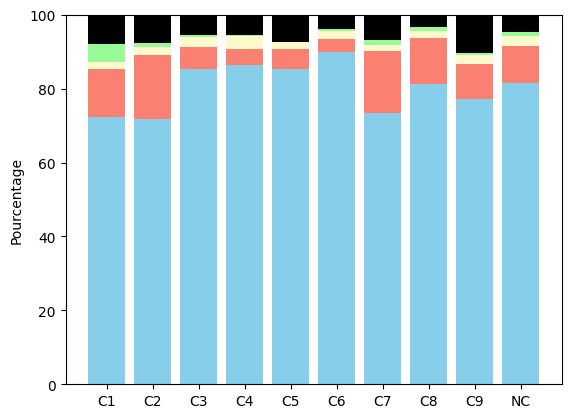

In [ ]:
# Répartition de assay_type dans cluster_organism
keys = list(count_cl.keys())

count_classes = {}
for classe in param["Assay Class"] :
    tot = []
    for key in keys:
        condition = (geosra_pd["assay_type"] == classe) & (geosra_pd["cluster_organism"] == key)
        tot.append(len(geosra_pd[condition]))
    count_classes[classe] = np.array(tot)

tot = []
for key in keys:
    condition = (~geosra_pd["assay_type"].isin(classes)) & (geosra_pd["cluster_organism"] == key)
    tot.append(len(geosra_pd[condition]))
count_classes["OTHER"] = np.array(tot)

total = np.zeros(len(keys))
for key in count_classes.keys():
    total += count_classes[key]

for key in count_classes.keys():
    count_classes[key] = count_classes[key] / total * 100

ind = np.arange(len(keys))
colors = {}
i = 0
for classe in param["Assay Class"]:
    colors[classe] = param["Assays Color"][i]
    i += 1
colors["OTHER"] = 'black'
bot = 0
for key in count_classes.keys():
    plt.bar(ind, count_classes[key], color=colors[key], bottom=bot)
    bot += count_classes[key]
plt.ylabel('Pourcentage')
plt.ylim(0,100)
plt.xticks(ind, keys)
plt.show()

In [ ]:
# Enregistrement des données avec release_year et cluster_organism
geosra_pd.to_parquet(param["GeoSRA DIR OUT"])

OSError: [Errno 28] Error writing bytes to file. Detail: [errno 28] No space left on device